# 고양이, 개 분류 - CNN v2
- Dropout 추가

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-01-18 02:26:07--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.128, 142.250.98.128, 142.250.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.2’

cats_and_dogs_filte 100%[===================>]  65.43M   198MB/s    in 0.3s    

2022-01-18 02:26:07 (198 MB/s) - ‘cats_and_dogs_filtered.zip.2’ saved [68606236/68606236]



In [3]:
!unzip cats_and_dogs_filtered.zip > /dev/null

In [4]:
#  !rm -rf cats_and_dogs_filtered

- 데이터 탐색

In [5]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [6]:
# 파일 이름
# 기존에 X_train, y_train은 변수로 설정했으나, 오늘 하게 될 내용은 파일로 저장해서 불러와야함
import os 
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])

['cat.976.jpg', 'cat.230.jpg', 'cat.493.jpg', 'cat.626.jpg', 'cat.186.jpg']
['dog.362.jpg', 'dog.98.jpg', 'dog.667.jpg', 'dog.766.jpg', 'dog.332.jpg']


In [7]:
# 파일 갯수
len(train_cats_fnames), len(train_dogs_fnames)

(1000, 1000)

- 이미지 확인

In [8]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
fname = os.path.join(train_cats_dir, 'cat.976.jpg')
fname

'cats_and_dogs_filtered/train/cats/cat.976.jpg'

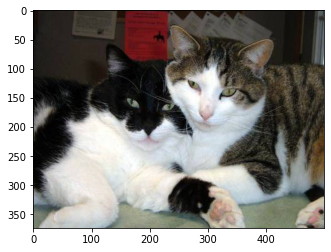

In [10]:
img = Image.open(fname)
plt.imshow(img)

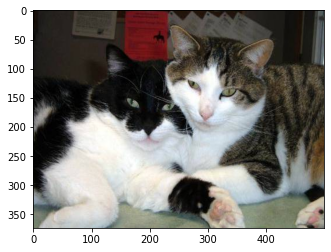

In [11]:
img = cv2.imread(fname)[:,:,::-1]
plt.imshow(img);

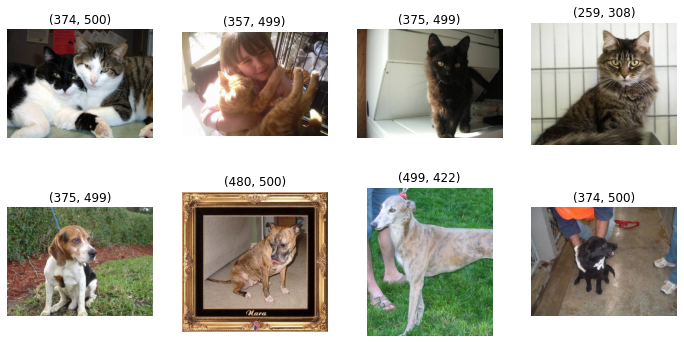

In [12]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])         # 사진의 크기가 제각각이라는 것을 확인할 수 있다. 

    plt.subplot(2,4,i+5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])

plt.show()

- 모델 구성

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [14]:
model = Sequential([ 
    Conv2D(16, kernel_size=(3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)        0

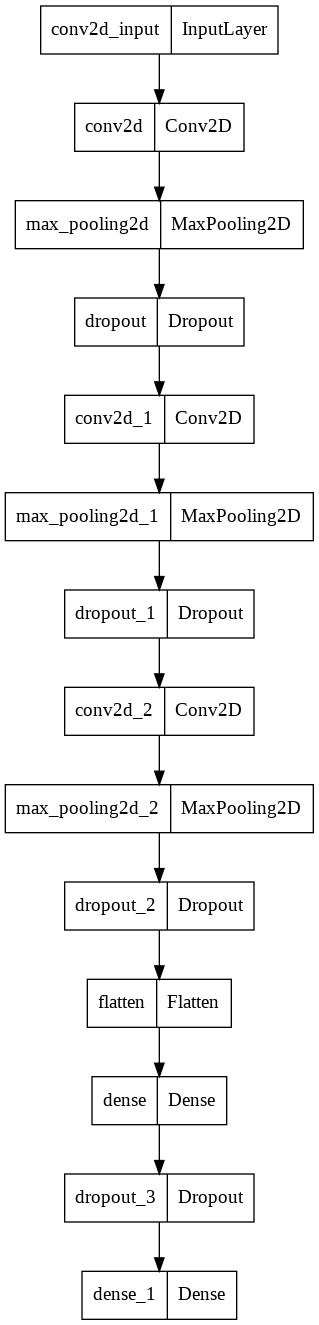

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model)

- 모델 설정

In [16]:
from tensorflow.keras.optimizers import RMSprop     # learning rate를 직접 지정할 수 있다. 

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8),      # 10^-8만큼 learning rate를 줄이겠다는 의미
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
0.001 - 0.001 * 1e-8

0.00099999999

- 파일에서 이미지 데이터 읽어오는 방법
    - `class_mode='binary'`: directory로 보관하면, 자동으로 train, test가 분할이 된다
        - cat:0, dog:1로 설정

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [19]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
train_dir

'cats_and_dogs_filtered/train'

- callback 정의

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-cat-dog-v2.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

- 모델 실행

In [22]:
hist = model.fit(
    train_generator, 
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=100,            # 한번의 epoch에서 사용할 batch의 갯수
    validation_steps=50,             # 한번의 epoch가 끝났을 때, 테스트에 사용되는 batch의 갯수
    verbose=2,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.69299, saving model to best-cat-dog-v2.h5
100/100 - 11s - loss: 1.0321 - accuracy: 0.4940 - val_loss: 0.6930 - val_accuracy: 0.5040 - 11s/epoch - 113ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 0.69299 to 0.68308, saving model to best-cat-dog-v2.h5
100/100 - 8s - loss: 0.7014 - accuracy: 0.5715 - val_loss: 0.6831 - val_accuracy: 0.5910 - 8s/epoch - 81ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 0.68308 to 0.63606, saving model to best-cat-dog-v2.h5
100/100 - 8s - loss: 0.6518 - accuracy: 0.6145 - val_loss: 0.6361 - val_accuracy: 0.6110 - 8s/epoch - 80ms/step
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.63606
100/100 - 8s - loss: 0.6080 - accuracy: 0.6970 - val_loss: 0.6405 - val_accuracy: 0.6480 - 8s/epoch - 78ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 0.63606 to 0.61381, saving model to best-cat-dog-v2.h5
100/100 - 8s - loss: 0.5663 - accuracy: 0.7210 - val_loss: 0.6138 - val_a

In [23]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

- 테스트 이미지 분류

In [24]:
from google.colab import files

up = files.upload()

Saving cat.jpg to cat.jpg
Saving dog1.jpg to dog1.jpg
Saving dog2.jpg to dog2.jpg
Saving puppy.jpg to puppy.jpg


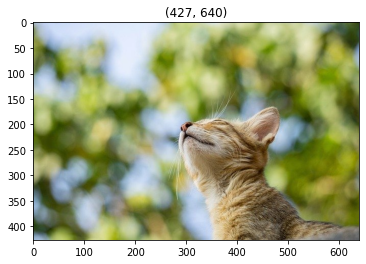

In [25]:
img = cv2.imread('cat.jpg')[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]);

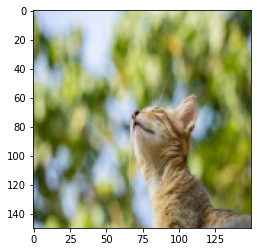

In [26]:
# 150 x 150 size
img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
plt.imshow(img);

In [27]:
best_model.predict(img.reshape(1,150,150,3))    # predict는 데이터가 여러개 들어오기를 기대함

array([[0.99995315]], dtype=float32)

In [28]:
for fname in up.keys():                 # up.keys(): filename
    img = cv2.imread(fname)[:,:,::-1]
    if sum(img.shape[:-1]) > 300:       # 150 x 150 보다 큰 이미지
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
    else:
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_CUBIC)
    classes = best_model.predict(img.reshape(1,150,150,3))
    print(f"{classes[0,0]: .4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

 1.0000 cat.jpg is a dog
 1.0000 dog1.jpg is a dog
 0.0000 dog2.jpg is a cat
 0.0000 puppy.jpg is a cat


- 학습과정 시각화

In [29]:
import numpy as np
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

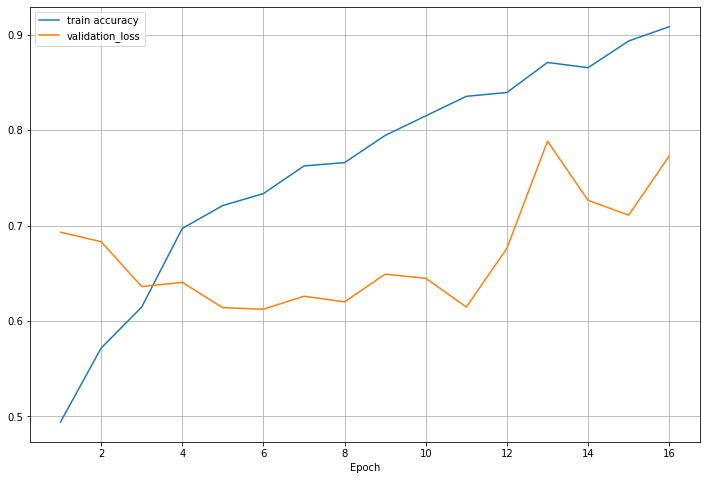

In [30]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation_loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()